In [24]:
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import requests
from PIL import Image
from io import BytesIO
from transformers import CLIPProcessor, CLIPModel
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn as nn

# ==============================
# Load and Preprocess Dataset
# ==============================

# Load dataset from CSV
data_str = "/content/politifact_articles_with_images (1).csv"

def load_dataset(file_path):
    """Load dataset from CSV or Excel."""
    if file_path.endswith('.csv'):
        df = pd.read_csv(file_path)
    elif file_path.endswith('.xlsx'):
        df = pd.read_excel(file_path)
    else:
        raise ValueError("Unsupported file format. Use CSV or Excel.")

    return df

# Preprocess the dataset
# Preprocess the dataset
def preprocess_dataset(df):
    # Label mapping
    real_labels = ['true', 'mostly true', 'half true']
    fake_labels = ['false', 'mostly false', 'pants on fire']

    # Function to map labels to binary
    def map_to_binary(rating):
        rating = str(rating).strip().lower()
        if rating in real_labels:
            return 1  # Real news
        elif rating in fake_labels:
            return 0  # Fake news
        else:
            return None  # Filter out invalid labels

    # Apply label mapping
    df['Label'] = df['Rating'].apply(map_to_binary)

    # Remove rows with invalid labels
    df = df.dropna(subset=['Label'])

    # Ensure label type is integer
    df['Label'] = df['Label'].astype(int)

    return df


# Download images
def download_images(df, image_dir='./images'):
    """Download images from URLs and save them locally."""
    os.makedirs(image_dir, exist_ok=True)
    image_paths = []

    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Downloading images"):
        image_url = row.get('Image URL', None)

        if pd.isna(image_url) or image_url is None or image_url == 'N/A' or image_url == 'nan':
            image_paths.append(None)
            continue

        try:
            image_filename = f"{idx}.jpg"
            image_path = os.path.join(image_dir, image_filename)

            if not os.path.exists(image_path):
                response = requests.get(image_url)
                img = Image.open(BytesIO(response.content))
                img.save(image_path)

            image_paths.append(image_path)
        except Exception as e:
            print(f"Error downloading image {image_url}: {e}")
            image_paths.append(None)

    df['local_image_path'] = image_paths
    return df


# ==============================
# CLIP Classifier
# ==============================

class CLIPClassifier(nn.Module):
    def __init__(self, clip_model_name="openai/clip-vit-base-patch32", num_classes=2):
        super(CLIPClassifier, self).__init__()
        self.clip = CLIPModel.from_pretrained(clip_model_name)

        # Freeze CLIP parameters
        for param in self.clip.parameters():
            param.requires_grad = False

        hidden_size = self.clip.config.projection_dim

        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_classes)
        )

    def forward(self, input_ids=None, attention_mask=None, pixel_values=None, return_loss=False, labels=None):
        outputs = self.clip(input_ids=input_ids, attention_mask=attention_mask, pixel_values=pixel_values)

        text_embeds = outputs.text_embeds
        logits = self.classifier(text_embeds)

        loss = None
        if return_loss and labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)

        return logits, loss


# ==============================
# PyTorch Dataset
# ==============================

class FakeNewsDataset(Dataset):
    def __init__(self, dataframe, processor, text_column='Claim', label_column='Label', image_column='local_image_path'):
        self.dataframe = dataframe
        self.processor = processor
        self.text_column = text_column
        self.label_column = label_column
        self.image_column = image_column

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]

        text = row[self.text_column]
        label = row[self.label_column]
        image_path = row[self.image_column]

        if pd.isna(image_path) or image_path is None:
            image = Image.new('RGB', (224, 224), color='white')
        else:
            try:
                image = Image.open(image_path).convert('RGB')
            except:
                image = Image.new('RGB', (224, 224), color='white')

        inputs = self.processor(
            text=text,
            images=image,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=77
        )

        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        inputs['labels'] = torch.tensor(label, dtype=torch.long)

        return inputs


# ==============================
# Model Training
# ==============================

def train_vlm(model, train_loader, val_loader, device, num_epochs=10, learning_rate=5e-5):
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    training_stats = {'train_loss': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            batch = {k: v.to(device) for k, v in batch.items()}
            labels = batch.pop('labels')

            logits, _ = model(**batch, return_loss=False)
            loss = criterion(logits, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        training_stats['train_loss'].append(avg_train_loss)

        model.eval()
        total_val_loss = 0
        all_preds, all_labels = [], []

        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                batch = {k: v.to(device) for k, v in batch.items()}
                labels = batch.pop('labels')

                logits, _ = model(**batch, return_loss=False)
                loss = criterion(logits, labels)

                total_val_loss += loss.item()
                preds = torch.argmax(logits, dim=1)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        avg_val_loss = total_val_loss / len(val_loader)
        val_acc = accuracy_score(all_labels, all_preds)

        training_stats['val_loss'].append(avg_val_loss)
        training_stats['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return model, training_stats


# ==============================
# Execute Workflow
# ==============================

# Load and preprocess the dataset
df = load_dataset(data_str)
df = preprocess_dataset(df)
df = download_images(df)

# Split dataset
train_df, val_df = train_test_split(df, test_size=0.3, random_state=42)

# Initialize the model and processor
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model = CLIPClassifier()

# Create datasets and loaders
train_dataset = FakeNewsDataset(train_df, processor)
val_dataset = FakeNewsDataset(val_df, processor)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train the model
model, training_stats = train_vlm(model, train_loader, val_loader, device)


Epoch 1/10 - Validation: 100%|██████████| 270/270 [00:16<00:00, 16.43it/s]


Epoch 1 - Train Loss: 0.6716, Val Loss: 0.6367, Val Acc: 0.7583


Epoch 2/10 - Validation: 100%|██████████| 270/270 [00:16<00:00, 16.71it/s]


Epoch 2 - Train Loss: 0.5913, Val Loss: 0.5477, Val Acc: 0.7593


Epoch 3/10 - Validation: 100%|██████████| 270/270 [00:16<00:00, 16.73it/s]


Epoch 3 - Train Loss: 0.5201, Val Loss: 0.4946, Val Acc: 0.7741


Epoch 4/10 - Validation: 100%|██████████| 270/270 [00:16<00:00, 16.60it/s]


Epoch 4 - Train Loss: 0.4844, Val Loss: 0.4715, Val Acc: 0.7750


Epoch 5/10 - Validation: 100%|██████████| 270/270 [00:15<00:00, 16.88it/s]


Epoch 5 - Train Loss: 0.4648, Val Loss: 0.4611, Val Acc: 0.7778


Epoch 6/10 - Validation: 100%|██████████| 270/270 [00:15<00:00, 16.99it/s]


Epoch 6 - Train Loss: 0.4526, Val Loss: 0.4513, Val Acc: 0.7806


Epoch 7/10 - Validation: 100%|██████████| 270/270 [00:16<00:00, 16.70it/s]


Epoch 7 - Train Loss: 0.4426, Val Loss: 0.4494, Val Acc: 0.7815


Epoch 8/10 - Validation: 100%|██████████| 270/270 [00:16<00:00, 16.85it/s]


Epoch 8 - Train Loss: 0.4357, Val Loss: 0.4475, Val Acc: 0.7796


Epoch 9/10 - Validation: 100%|██████████| 270/270 [00:16<00:00, 16.80it/s]


Epoch 9 - Train Loss: 0.4278, Val Loss: 0.4486, Val Acc: 0.7769


Epoch 10/10 - Validation: 100%|██████████| 270/270 [00:16<00:00, 16.75it/s]

Epoch 10 - Train Loss: 0.4229, Val Loss: 0.4424, Val Acc: 0.7806



✅ Accuracy: 0.7806


📊 Classification Report:

              precision    recall  f1-score   support

        Fake       0.76      0.79      0.77       513
        Real       0.80      0.77      0.79       567

    accuracy                           0.78      1080
   macro avg       0.78      0.78      0.78      1080
weighted avg       0.78      0.78      0.78      1080



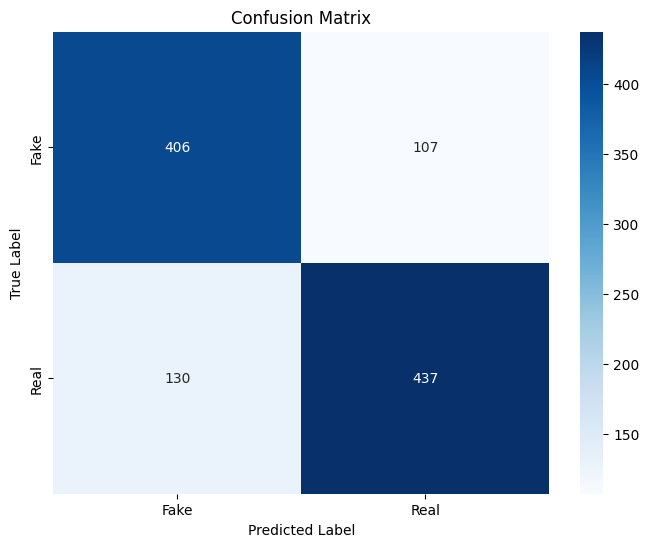

In [50]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, processor, data_loader, device):
    """
    Evaluate the model and print confusion matrix and metrics.

    Args:
    - model: Trained CLIP model
    - processor: CLIPProcessor for preprocessing
    - data_loader: DataLoader for validation/test dataset
    - device: Device (CPU or GPU)

    Returns:
    - Confusion matrix and classification report
    """
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in data_loader:
            batch = {k: v.to(device) for k, v in batch.items()}

            labels = batch.pop('labels')

            # Perform inference
            logits, _ = model(**batch, return_loss=False)

            # Get predictions
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Print accuracy and classification report
    acc = accuracy_score(all_labels, all_preds)
    print(f"\n✅ Accuracy: {acc:.4f}\n")

    class_report = classification_report(all_labels, all_preds, target_names=["Fake", "Real"])
    print("\n📊 Classification Report:\n")
    print(class_report)

    # Generate and display confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    return conf_matrix, class_report

  # Evaluate the model on the validation set
conf_matrix, class_report = evaluate_model(model, processor, val_loader, device)



In [25]:
# ==============================
# Save the Trained Model
# ==============================
model_save_path = "./clip_fake_news_classifier1.pth"

# Save the model state_dict
torch.save(model.state_dict(), model_save_path)
print(f"Model saved at {model_save_path}")


Model saved at ./clip_fake_news_classifier1.pth


In [26]:
# ==============================
# Load the Saved Model
# ==============================
model_load_path = "./clip_fake_news_classifier1.pth"

# Initialize the model
model = CLIPClassifier()
model.load_state_dict(torch.load(model_load_path))
model.to(device)
model.eval()

print(f"Model loaded from {model_load_path}")


Model loaded from ./clip_fake_news_classifier1.pth


In [39]:
def predict(model, processor, text=None, image_path=None, device='cpu'):
    """
    Perform inference on a single text, image, or both.

    Args:
    - model: Trained CLIP model
    - processor: CLIPProcessor for preprocessing
    - text: Claim text (str) [Optional]
    - image_path: Path to the image file (str) [Optional]
    - device: Device (CPU or GPU)

    Returns:
    - Prediction label (0 = Fake, 1 = Real) with confidence score
    """
    # Ensure at least one input is provided
    if not text and not image_path:
        raise ValueError("Either text or image path must be provided.")

    # Prepare image or use placeholder
    if image_path and os.path.exists(image_path) and image_path != 'N/A':
        image = Image.open(image_path).convert("RGB")
    elif image_path:
        print(f"Image not found: {image_path}. Using placeholder.")
        image = Image.new('RGB', (224, 224), color='white')
    else:
        image = None  # No image provided

    # --- Inference Logic ---
    with torch.no_grad():
        if text and image:
            # Text + Image Inference
            inputs = processor(
                text=text,
                images=image,
                return_tensors="pt",
                padding="max_length",
                truncation=True,
                max_length=77
            ).to(device)

            logits, _ = model(**inputs, return_loss=False)

        elif text:
            # Text-Only Inference
            inputs = processor(
                text=text,
                return_tensors="pt",
                padding="max_length",
                truncation=True,
                max_length=77
            ).to(device)

            text_features = model.clip.get_text_features(**inputs)
            logits = model.classifier(text_features)

        elif image:
            # Image-Only Inference
            inputs = processor(
                images=image,
                return_tensors="pt"
            ).to(device)

            image_features = model.clip.get_image_features(**inputs)
            logits = model.classifier(image_features)

        else:
            raise ValueError("Both text and image are missing!")

    # Get predictions and confidence scores
    probs = torch.softmax(logits, dim=1)
    pred_label = torch.argmax(probs, dim=1).item()
    confidence = probs[0][pred_label].item()

    label_str = "Real" if pred_label == 1 else "Fake"
    return label_str, confidence


In [47]:
text = "NASA confirmed water on Mars."
image_path = "./images/0.jpg"

label, confidence = predict(model, processor, text=text, image_path=image_path, device=device)
print(f"Prediction: {label}, Confidence: {confidence:.4f}")


Image not found: ./images/0.jpg. Using placeholder.
Prediction: Fake, Confidence: 0.9285


In [41]:
text = "The COVID-19 vaccine causes infertility."

label, confidence = predict(model, processor, text=text, device=device)
print(f"Text-Only Prediction: {label}, Confidence: {confidence:.4f}")


Text-Only Prediction: Fake, Confidence: 0.9999


In [44]:
image_path = "/content/images/1.jpg"

label, confidence = predict(model, processor, image_path=image_path, device=device)
print(f"Image-Only Prediction: {label}, Confidence: {confidence:.4f}")


Image-Only Prediction: Real, Confidence: 0.9718
